In [33]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shaunthesheep_microsoft_catsvsdogs_dataset_path = kagglehub.dataset_download('shaunthesheep/microsoft-catsvsdogs-dataset')

print('Data source import complete.')


Data source import complete.


In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [97]:
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [35]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaitanasuricha","key":"8de8fed113b252006a40ca11caf11f8e"}'}

In [36]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [38]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset -p /content/ --unzip

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
100% 786M/788M [00:07<00:00, 158MB/s]
100% 788M/788M [00:07<00:00, 116MB/s]


In [87]:
# Function to load a limited number of images
def load_images(folder, label, img_size=(224, 224), max_images=1040):
    images, labels = [], []
    filenames = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(filenames)  # Shuffle filenames to get a random subset
    filenames = filenames[:max_images]  # Limit the number of images

    for filename in filenames:
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img)
            img = preprocess_input(img)  # Preprocess for MobileNetV2
            images.append(img)
            labels.append(1 if label == "Dog" else 0)  # Convert to binary labels
        except Exception as e:
            print(f"Skipping corrupted image: {img_path}")
            continue
    return images, labels

In [88]:
# Load a limited dataset
dataset_path = "/content/PetImages"
dog_path = f"{dataset_path}/Dog"
cat_path = f"{dataset_path}/Cat"

dog_images, dog_labels = load_images(dog_path, label="Dog", max_images=520)
cat_images, cat_labels = load_images(cat_path, label="Cat", max_images=520)

data = np.array(dog_images + cat_images)
labels = np.array(dog_labels + cat_labels)

Skipping corrupted image: /content/PetImages/Cat/666.jpg


In [89]:
# Encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [90]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [91]:
# Data Augmentation
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [102]:
# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=out)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [103]:
# Train model with data augmentation
history = model.fit(
    data_generator.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.5098 - loss: 0.8381 - val_accuracy: 0.5962 - val_loss: 0.6449
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - accuracy: 0.6104 - loss: 0.6954 - val_accuracy: 0.8125 - val_loss: 0.4756
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.7585 - loss: 0.5173 - val_accuracy: 0.8846 - val_loss: 0.3644
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 199s 8s/step - accuracy: 0.8267 - loss: 0.4321 - val_accuracy: 0.9279 - val_loss: 0.2913
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.8215 - loss: 0.3935 - val_accuracy: 0.9471 - val_loss: 0.2339
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.8481 - loss: 0.3573 - val_accuracy: 0.9567 - val_loss: 0.1897
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - accuracy: 0.9102 - loss: 0.2815 - val_accuracy: 0.9663 - val_loss: 0.1579
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.9099 - loss: 0.2739 - val_accuracy: 0.9712 - v

In [86]:
# Evaluate model
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9699 - loss: 0.0837
Test Accuracy: 0.9760


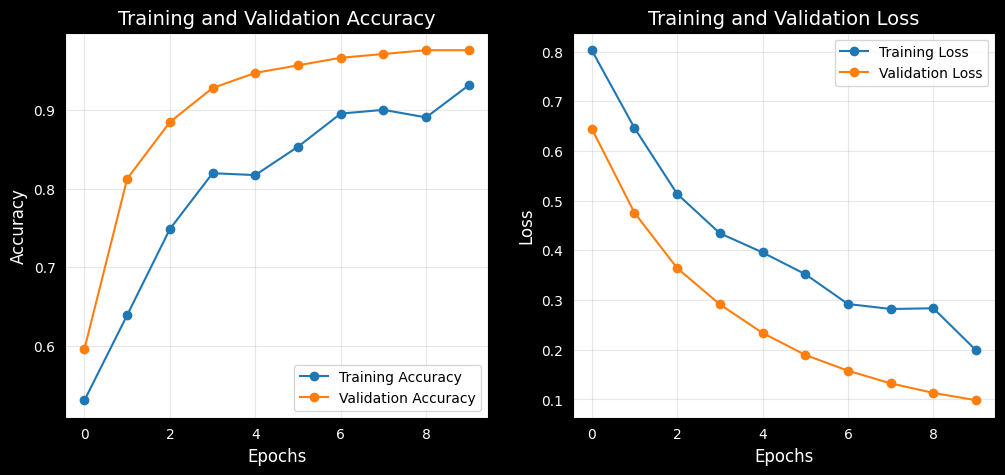

In [105]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.gcf().patch.set_facecolor("black")

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', []), marker='o', label="Training Accuracy")
plt.plot(history.history.get('val_accuracy', []), marker='o', label="Validation Accuracy")
plt.title("Training and Validation Accuracy", fontsize=14, color="white")
plt.xlabel("Epochs", fontsize=12, color="white")
plt.ylabel("Accuracy", fontsize=12, color="white")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(color="white")
plt.yticks(color="white")

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history.get('loss', []), marker='o', label="Training Loss")
plt.plot(history.history.get('val_loss', []), marker='o', label="Validation Loss")
plt.title("Training and Validation Loss", fontsize=14, color="white")
plt.xlabel("Epochs", fontsize=12, color="white")
plt.ylabel("Loss", fontsize=12, color="white")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(color="white")
plt.yticks(color="white")

plt.show()

In [106]:
model.save("mobilenetv2_cat_dog.h5")